In [125]:
from scipy.io import loadmat
import sys
data = loadmat('Brain.mat')
T1 = data['T1']
label = data['label']

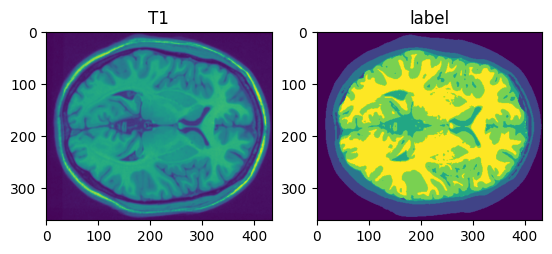

In [126]:
# show first image
import matplotlib.pyplot as plt

# show first image and label side by side
plt.subplot(1, 2, 1)
plt.imshow(T1[:, :, 0])
plt.title('T1')
plt.subplot(1, 2, 2)
plt.imshow(label[:, :, 0])
plt.title('label')
plt.show()

In [127]:
print("Image Shape:",T1.shape)
print("Label Shape:",label.shape)

Image Shape: (362, 434, 10)
Label Shape: (362, 434, 10)


Otsu Thresholding

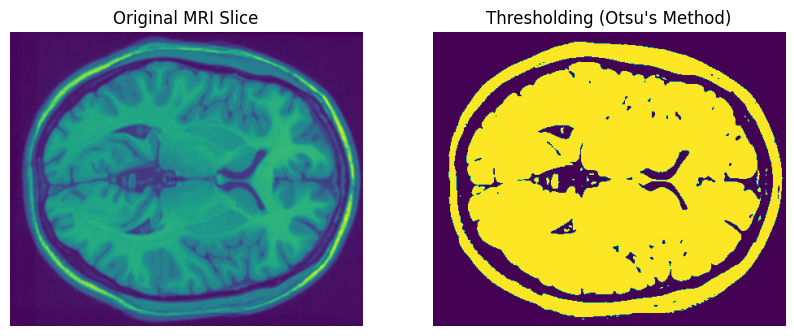

In [128]:
from skimage.filters import threshold_otsu

# Apply Otsu's method for thresholding
mri_slice = T1[:, :, 0]
threshold_value = threshold_otsu(mri_slice)
binary_thresholded = mri_slice > threshold_value

# Visualize the results
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(mri_slice)
plt.title('Original MRI Slice')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(binary_thresholded)
plt.title("Thresholding (Otsu's Method)")
plt.axis('off')

plt.show()

Multi Otsu Thresholding

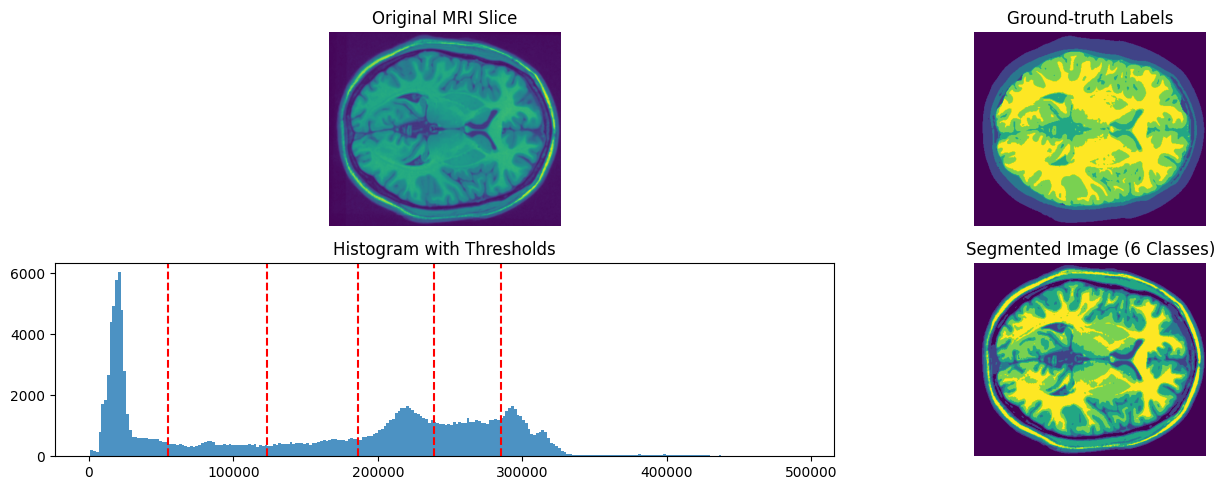

In [129]:
from skimage.filters import threshold_multiotsu
import numpy as np
from skimage.filters import gaussian

# Apply Gaussian blur
smoothed_image = gaussian(mri_slice, sigma=1)

# Example 3D MRI data
# Assuming T1 is a 3D MRI image array, with one slice selected
mri_slice = T1[:, :, 0]  # Select one slice

# Apply multi-level thresholding (e.g., 3 classes)
num_classes = 6
thresholds = threshold_multiotsu(smoothed_image, classes=num_classes)

# Segment the image into regions based on thresholds
regions = np.digitize(mri_slice, bins=thresholds)

# Visualize the results
plt.figure(figsize=(15, 5))

# Original image
plt.subplot(2, 2, 1)
plt.imshow(mri_slice, cmap='viridis')
plt.title('Original MRI Slice')
plt.axis('off')

# Ground-truth labels
plt.subplot(2, 2, 2)
plt.imshow(label[:, :, 0], cmap='viridis')
plt.title('Ground-truth Labels')
plt.axis('off')

# Show thresholds on the histogram
plt.subplot(2, 2, 3)
plt.hist(mri_slice.ravel(), bins=256, alpha=0.8)
for t in thresholds:
    plt.axvline(t, color='r', linestyle='--')
plt.title('Histogram with Thresholds')

# Multi-level segmentation result
plt.subplot(2, 2, 4)
plt.imshow(regions, cmap='viridis')
plt.title(f'Segmented Image ({num_classes} Classes)')
plt.axis('off')

plt.tight_layout()
plt.show()

Image Filtering (Canny & Sobel Edge Detection) 

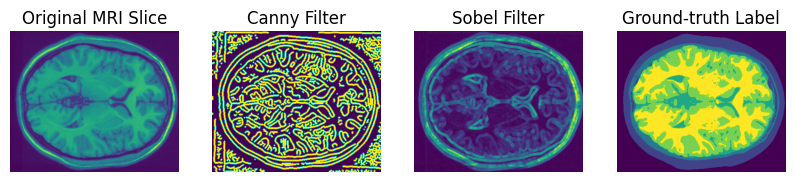

In [130]:
from skimage.filters import sobel
from skimage import feature
from skimage.morphology import dilation, disk

# Apply Sobel filter for edge detection
# edges = sobel(mri_slice
edges = sobel(mri_slice)
edges_dilated = dilation(edges, disk(2))  # Dilation to enhance edges

# Apply Canny edge detection
canny_edges = feature.canny(mri_slice, sigma=3)
canny_edges_dilated = dilation(canny_edges, disk(2))  # Dilation to enhance edges

# Visualize the results
plt.figure(figsize=(10, 5))
plt.subplot(1, 4, 1)
plt.imshow(mri_slice)
plt.title('Original MRI Slice')
plt.axis('off')

plt.subplot(1, 4, 2)
plt.imshow(canny_edges_dilated)
plt.title('Canny Filter')
plt.axis('off')

plt.subplot(1, 4, 3)
plt.imshow(edges_dilated)
plt.title('Sobel Filter')
plt.axis('off')

plt.subplot(1, 4, 4)
plt.imshow(label[:, :, 0])
plt.title('Ground-truth Label')
plt.axis('off')

plt.show()

K-Means Clustering

(157108,)
(157108, 3)


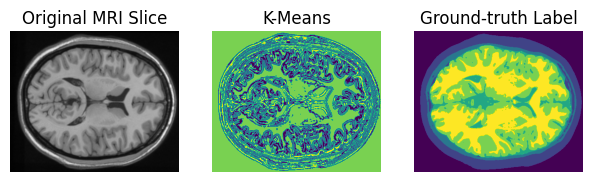

In [160]:
from sklearn.cluster import KMeans
from skimage.filters import gaussian
from skimage import exposure


# Flatten for clustering
pixels = mri_slice.flatten()
print(pixels.shape)

edges = edges.flatten()

# Normalise the image using z-score normalisation
pixels = (pixels- np.mean(pixels)) / np.std(pixels)

# Apply median filter first, then Gaussian smoothing
smoothed_image = gaussian(pixels, sigma=8)

stacked_image = np.stack((pixels, edges, smoothed_image), axis=1)
print(stacked_image.shape)

# Define KMeans with different initialisation and parameters
kmeans = KMeans(
    n_clusters=6,
    random_state=3
)

# Fit the KMeans model
kmeans.fit(stacked_image)
clustered = kmeans.labels_.reshape(mri_slice.shape)

# Visualise the results
plt.figure(figsize=(10, 5))
plt.subplot(1, 4, 1)
plt.imshow(mri_slice, cmap='gray')
plt.title('Original MRI Slice')
plt.axis('off')

plt.subplot(1, 4, 2)
plt.imshow(clustered)
plt.title('K-Means')
plt.axis('off')

plt.subplot(1, 4, 3)
plt.imshow(label[:, :, 0], cmap='viridis')
plt.title('Ground-truth Label')
plt.axis('off')

plt.axis('off')

plt.show()

Comparing the results of the above methods

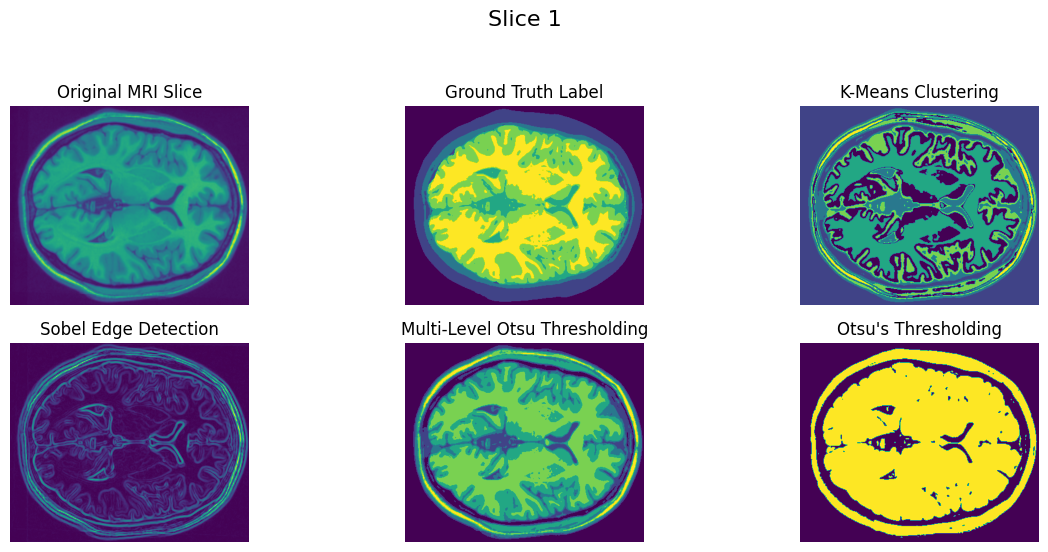

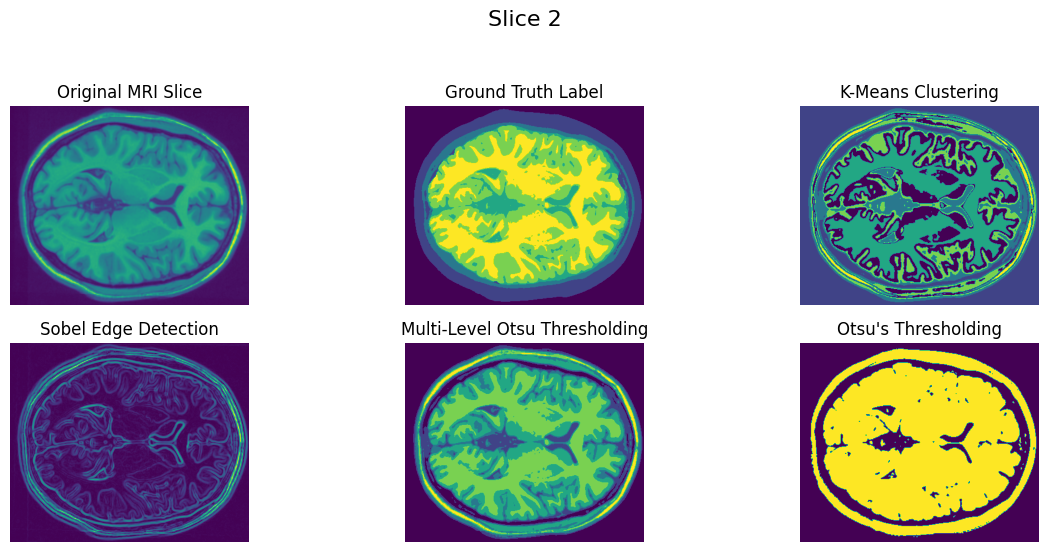

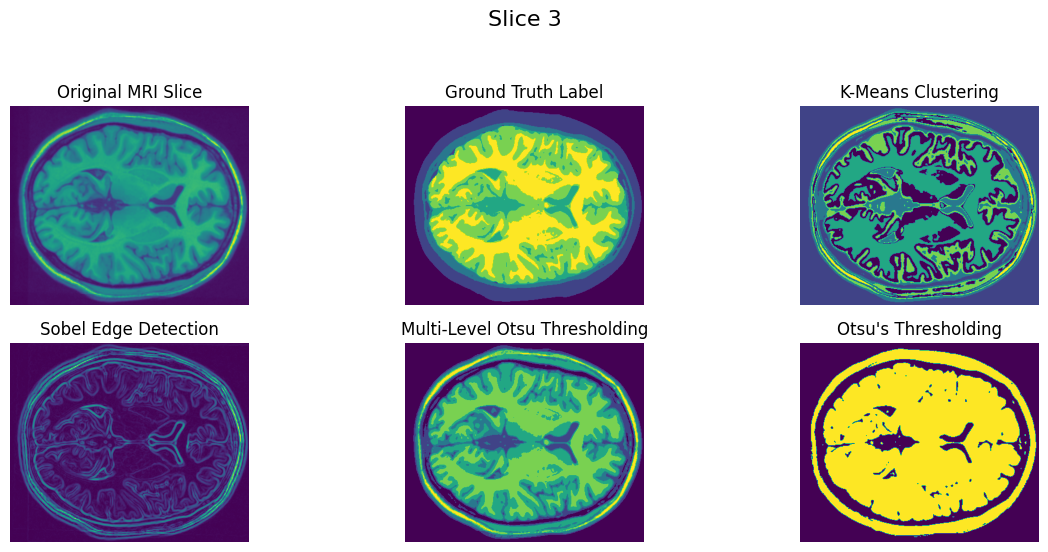

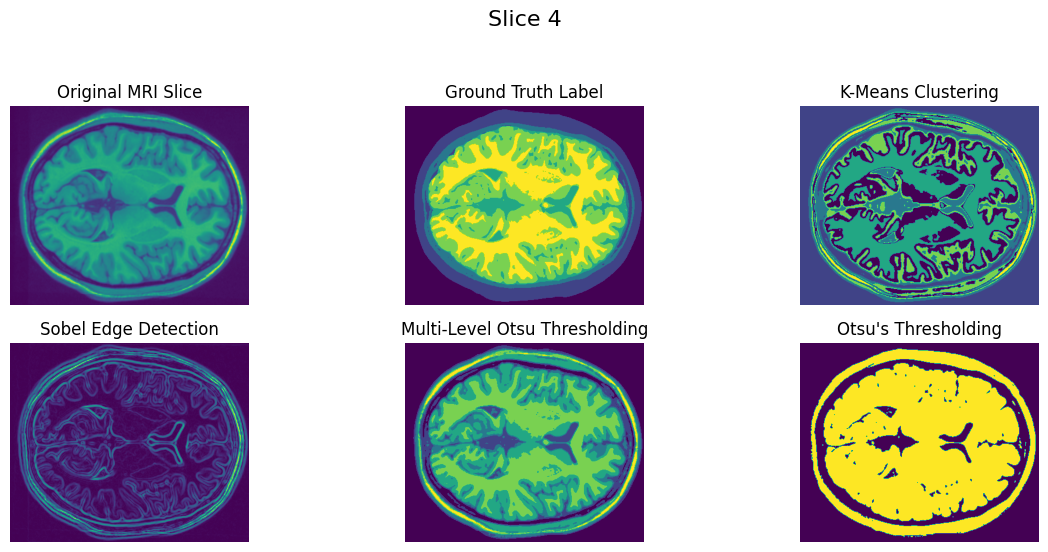

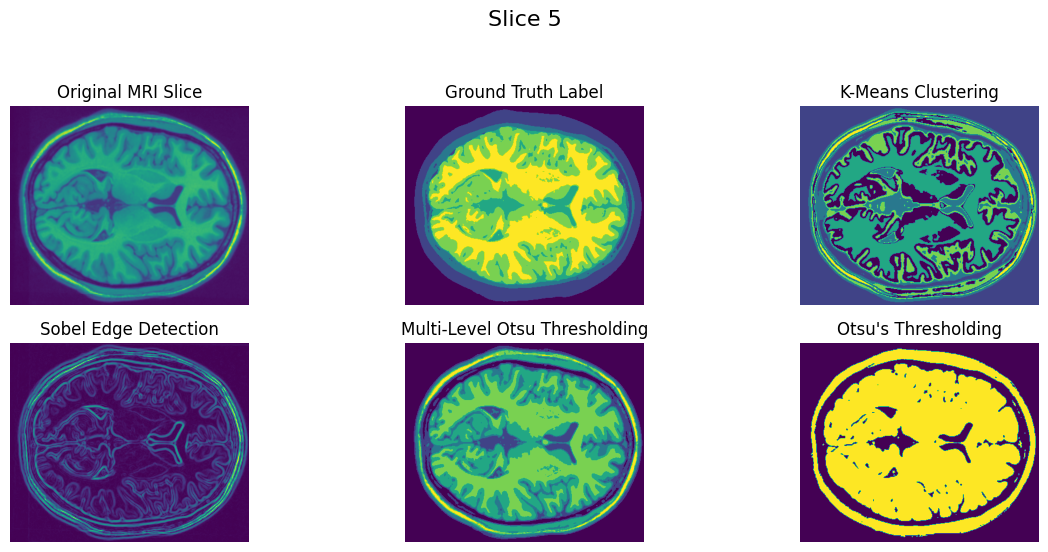

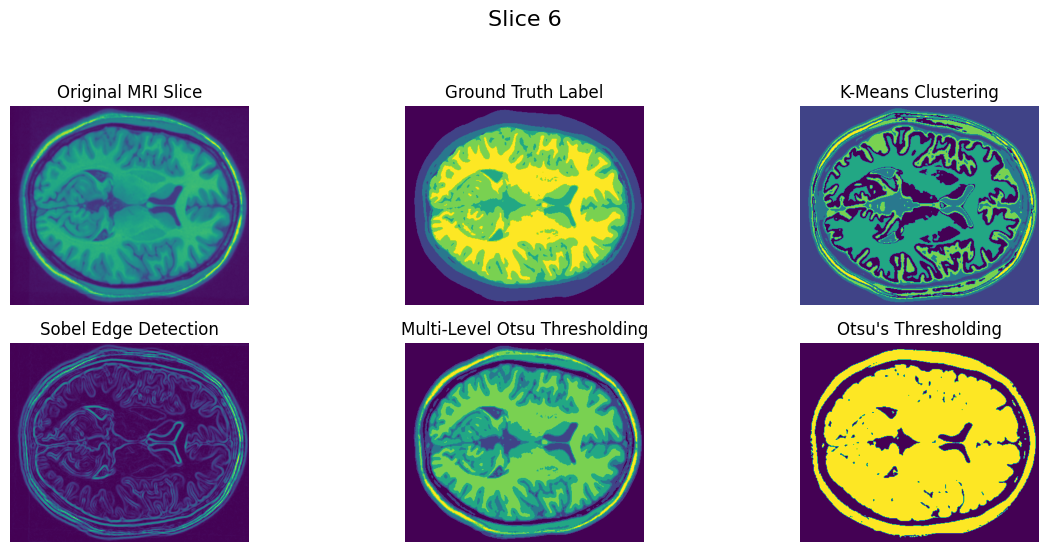

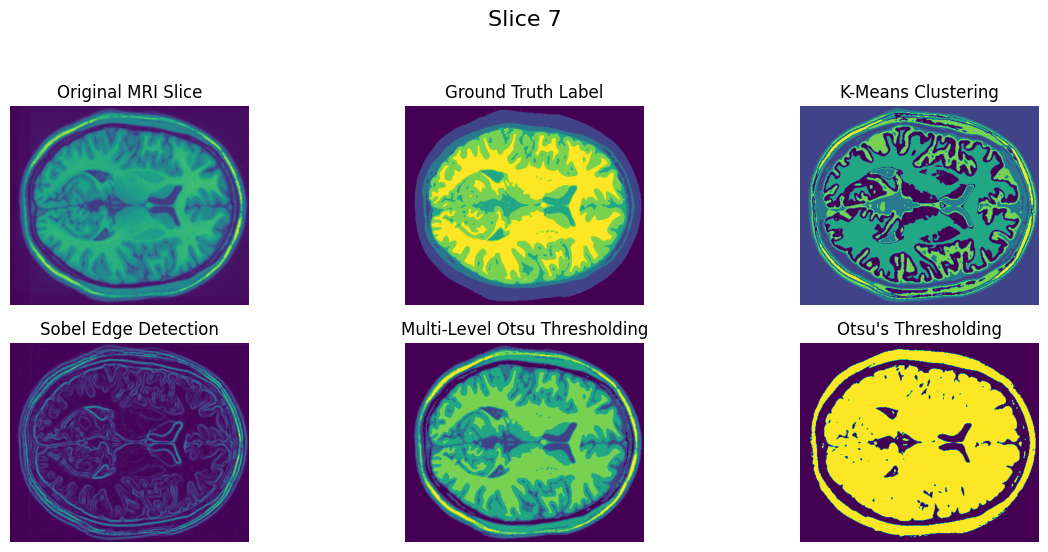

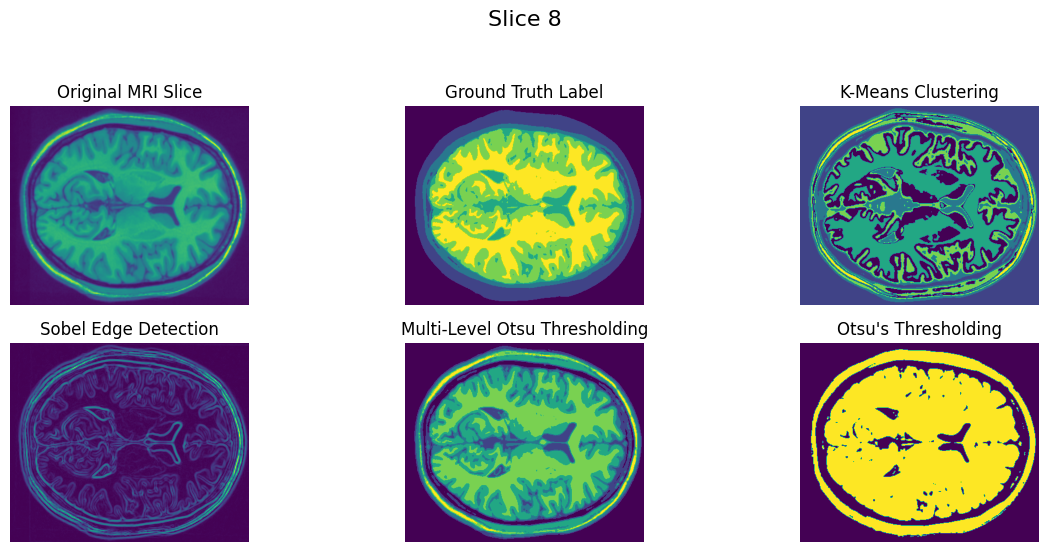

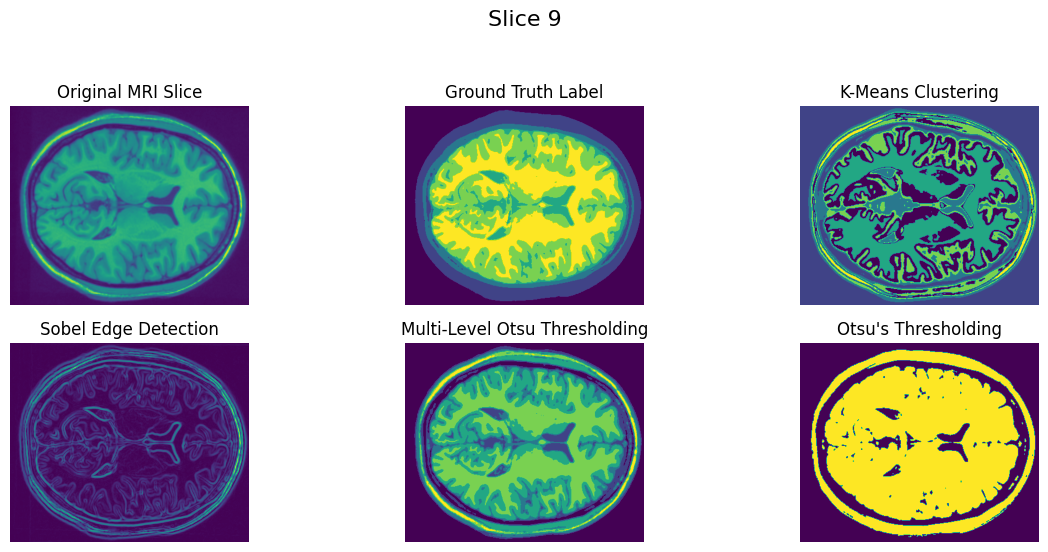

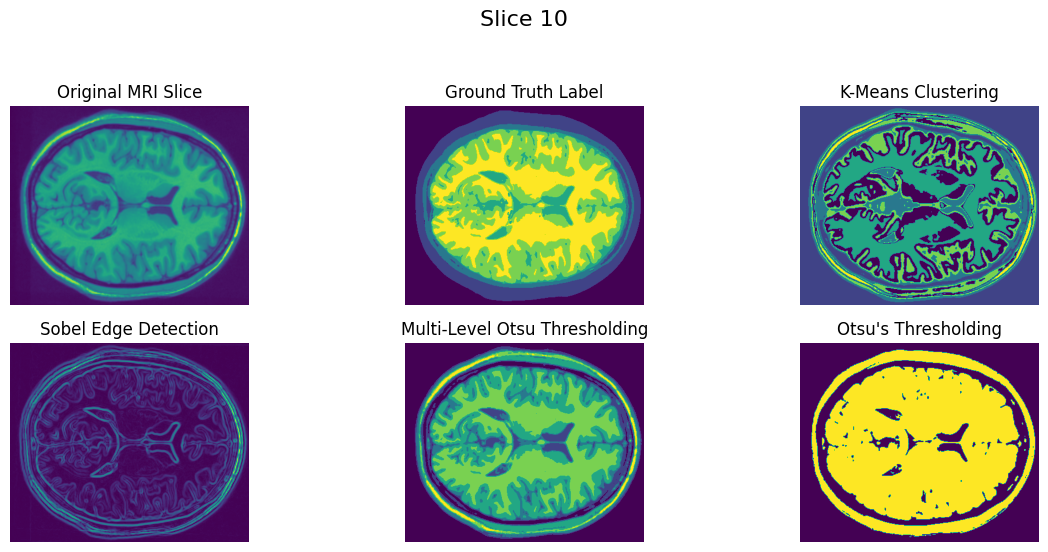

In [132]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from sklearn.cluster import KMeans
from skimage.filters import sobel, threshold_otsu
from skimage.morphology import dilation, disk

# Load data
data = loadmat('Brain.mat')
T1 = data['T1']  # Shape: (362, 434, 10)
label = data['label']  # Shape: (362, 434, 10)

# Number of slices
num_slices = T1.shape[2]

# Loop through all slices and apply each method
for i in range(num_slices):
    mri_slice = T1[:, :, i]
    true_label = label[:, :, i]

    #################################################

    # Rescale the image to [0, 1]
    scaled_mri_slice = (mri_slice - np.mean(mri_slice)) / np.std(mri_slice)

    # Apply median filter first, then Gaussian smoothing
    smoothed_image = gaussian(scaled_mri_slice, sigma=1)

    # Flatten for clustering
    pixels = smoothed_image.flatten().reshape(-1, 1)

    # Define KMeans with different initialisation and parameters
    kmeans = KMeans(
        n_clusters=6,
        random_state=3
    ).fit(pixels)
    ##################################################


    ##################################################
    # Apply Multi-Otsu Thresholding
    num_classes = 6
    thresholds = threshold_multiotsu(mri_slice, classes=num_classes, nbins=256)

    # Segment the image into regions based on thresholds
    regions = np.digitize(mri_slice, bins=thresholds)
    ##################################################


    ##################################################
    # Apply Sobel Edge Detection + Dilation
    edges = sobel(mri_slice)
    edges_dilated = dilation(edges, disk(2))

    # Apply Canny edge detection
    canny_edges = feature.canny(mri_slice, sigma=3)
    canny_edges_dilated = dilation(canny_edges, disk(2))
    
    ##################################################
    # Apply Otsu's Thresholding
    threshold_value = threshold_otsu(mri_slice)
    binary_thresholded = mri_slice > threshold_value
    ##################################################

    # Visualize results for the current slice
    plt.figure(figsize=(12, 8))
    plt.suptitle(f'Slice {i + 1}', fontsize=16)

    
    plt.subplot(3, 3, 1)
    plt.imshow(mri_slice)
    plt.title('Original MRI Slice')
    plt.axis('off')
    
    plt.subplot(3, 3, 2)
    plt.imshow(true_label, cmap='viridis')
    plt.title('Ground Truth Label')
    plt.axis('off')
    
    plt.subplot(3, 3, 3)
    plt.imshow(clustered, cmap='viridis')
    plt.title('K-Means Clustering')
    plt.axis('off')
    
    plt.subplot(3, 3, 4)
    plt.imshow(edges)
    plt.title('Sobel Edge Detection')
    plt.axis('off')
    
    plt.subplot(3, 3, 5)
    plt.imshow(regions, cmap='viridis')
    plt.title('Multi-Level Otsu Thresholding')
    plt.axis('off')
    
    plt.subplot(3, 3, 6)
    plt.imshow(binary_thresholded, cmap='viridis')
    plt.title("Otsu's Thresholding") 
    plt.axis('off')
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

Model Evaluation & Comparison

In [133]:
import pandas as pd
from scipy.ndimage import distance_transform_edt
from skimage.segmentation import find_boundaries
from skimage.filters import sobel, threshold_otsu, threshold_multiotsu
from skimage.morphology import dilation, disk
from sklearn.metrics import confusion_matrix
from scipy.optimize import linear_sum_assignment

# Function to align predicted labels with ground truth labels
def align_labels(predicted, ground_truth, num_classes=6):
    conf_matrix = confusion_matrix(ground_truth.flatten(), predicted.flatten(), labels=np.arange(num_classes))
    row_ind, col_ind = linear_sum_assignment(-conf_matrix)  # Negative for maximization
    label_mapping = {col: row for row, col in zip(row_ind, col_ind)}  # Map predicted labels to ground truth
    
    # Apply the mapping to predicted labels
    relabeled_pred = np.vectorize(lambda x: label_mapping.get(x, x))(predicted)
    return relabeled_pred

# Existing function definitions
def compute_surface_distances(predicted, ground_truth, voxel_spacing=1.0):
    boundary_pred = find_boundaries(predicted, mode='inner')
    boundary_gt = find_boundaries(ground_truth, mode='inner')

    dt_gt = distance_transform_edt(~boundary_gt, sampling=voxel_spacing)
    dt_pred = distance_transform_edt(~boundary_pred, sampling=voxel_spacing)

    surface_distance_gt_to_pred = dt_pred[boundary_gt]
    surface_distance_pred_to_gt = dt_gt[boundary_pred]

    return surface_distance_gt_to_pred, surface_distance_pred_to_gt

def compute_nsd(predicted, ground_truth, threshold=1.0):
    dist_gt_to_pred, dist_pred_to_gt = compute_surface_distances(predicted, ground_truth)
    surface_distances = np.concatenate([dist_gt_to_pred, dist_pred_to_gt])
    nsd = np.mean(surface_distances <= threshold)
    return nsd

def compute_max_iou(predicted, ground_truth, num_classes=6):
    iou_scores = []
    pred_flat = predicted.flatten()
    gt_flat = ground_truth.flatten()
    
    for cls_pred in range(num_classes):
        pred_cls = (pred_flat == cls_pred).astype(int)
        max_iou = 0
        for cls_gt in range(num_classes):
            gt_cls = (gt_flat == cls_gt).astype(int)
            intersection = np.sum(pred_cls * gt_cls)
            union = np.sum(pred_cls) + np.sum(gt_cls) - intersection
            iou = intersection / (union + 1e-6)
            max_iou = max(max_iou, iou)
        iou_scores.append(max_iou)
    
    average_iou = np.mean(iou_scores)
    return iou_scores, average_iou

def compute_metrics(predicted, ground_truth, num_classes=6):
    metrics = {'Class': list(range(num_classes)), 'Dice': [], 'IoU': [], 'Accuracy': [], 'NSD': []}
    pred_flat = predicted.flatten()
    gt_flat = ground_truth.flatten()
    
    iou_scores, _ = compute_max_iou(predicted, ground_truth, num_classes)
    
    for cls in range(num_classes):
        pred_cls = (pred_flat == cls).astype(int)
        gt_cls = (gt_flat == cls).astype(int)
        intersection = np.sum(pred_cls * gt_cls)
        dice = (2.0 * intersection) / (np.sum(pred_cls) + np.sum(gt_cls) + 1e-6)
        accuracy = np.mean(pred_cls == gt_cls)
        nsd = compute_nsd(pred_cls.reshape(predicted.shape), gt_cls.reshape(ground_truth.shape))
        
        metrics['Dice'].append(dice)
        metrics['IoU'].append(iou_scores[cls])
        metrics['Accuracy'].append(accuracy)
        metrics['NSD'].append(nsd)
    
    df_metrics = pd.DataFrame(metrics)
    return df_metrics

In [134]:
# Assuming these functions are defined elsewhere:
# align_labels(predicted, true) -> Align clusters with ground-truth labels
# compute_metrics(predicted, true) -> Returns a DataFrame of metrics for each class

# Initialize an empty list to store metrics DataFrames for each slice
all_metrics = []

# Loop through all slices and apply each method
for i in range(num_slices):
    mri_slice = T1[:, :, i]
    true_label = label[:, :, i]

    # # Flatten for clustering
    pixels = mri_slice.flatten().reshape(-1, 1)

    # # normalize the image
    pixels = (pixels - np.mean(pixels)) / np.std(pixels)

    # apply gaussian filter
    pixels = gaussian(pixels, sigma=1)

    # Define and fit KMeans
    kmeans = KMeans(n_clusters=6, random_state=3).fit(pixels)

    # Predict labels and align with the ground-truth labels
    predicted_kmeans = kmeans.labels_.reshape(mri_slice.shape)
    aligned_kmeans = align_labels(predicted_kmeans, true_label)
    
    # Compute metrics and store the DataFrame in the list
    metrics_df = compute_metrics(aligned_kmeans, true_label)
    all_metrics.append(metrics_df)

# Combine all metrics DataFrames
combined_metrics = pd.concat(all_metrics)

# Calculate the average metrics across all slices
average_metrics = combined_metrics.groupby('Class').mean()

# Print the average metrics
print("Average KMeans Clustering Metrics:")
print(average_metrics)

print(average_metrics.mean())

Average KMeans Clustering Metrics:
           Dice       IoU  Accuracy       NSD
Class                                        
0      0.921885  0.855096  0.955483  0.355489
1      0.289231  0.235952  0.812297  0.194574
2      0.068673  0.241824  0.871229  0.100788
3      0.425328  0.270415  0.905009  0.387274
4      0.764314  0.620917  0.889571  0.566757
5      0.759068  0.630192  0.908926  0.538781
Dice        0.538083
IoU         0.475733
Accuracy    0.890419
NSD         0.357277
dtype: float64


In [ ]:
results = {'kmeans': [], 'multi_otsu': [], 'sobel_edges': [], 'otsu_thresholding': [], 'canny_edges': []}

# Loop through all slices and apply each method
for i in range(num_slices):
    mri_slice = T1[:, :, i]
    true_label = label[:, :, i]

    ################################################## 
    # Apply KMeans Clustering
    #  Normalise the image using z-score normalisation
    norm_mri_slice = (mri_slice - np.mean(mri_slice)) / np.std(mri_slice)

    # # Apply median filter first, then Gaussian smoothing
    smoothed_image = gaussian(norm_mri_slice, sigma=1)

    # Flatten for clustering
    pixels = smoothed_image.flatten().reshape(-1, 1)

    # Define KMeans with different initialisation and parameters
    kmeans = KMeans(
        n_clusters=6, random_state=3
    ).fit(pixels)

    predicted_kmeans = kmeans.labels_.reshape(mri_slice.shape)
    aligned_kmeans = align_labels(predicted_kmeans, true_label)
    results['kmeans'].append(compute_metrics(aligned_kmeans, true_label))
    ##################################################


    ##################################################
    # Apply Multi-Otsu Thresholding
    # Optionally, add edge information
    num_classes = 6
    thresholds = threshold_multiotsu(mri_slice, classes=num_classes)

    # Segment the image into regions based on thresholds
    regions = np.digitize(mri_slice, bins=thresholds)
    aligned_multi_otsu = align_labels(regions, true_label)
    results['multi_otsu'].append(compute_metrics(aligned_multi_otsu, true_label))
    ##################################################


    ##################################################
    # Apply Sobel Edge Detection + Dilation
    edges = sobel(mri_slice)
    edges_dilated = dilation(edges, disk(2))
    sobel_thresholded = (edges_dilated > 0.5).astype(int)
    sobel_aligned = align_labels(sobel_thresholded, true_label)  # Align labels here
    results['sobel_edges'].append(compute_metrics(sobel_aligned, true_label))

    # Apply Canny edge detection
    canny_edges = feature.canny(mri_slice, sigma=3)
    canny_edges_dilated = dilation(canny_edges, disk(2))
    canny_thresholded = (canny_edges_dilated > 0.5).astype(int)
    canny_aligned = align_labels(canny_thresholded, true_label)  # Align labels here
    results['canny_edges'].append(compute_metrics(canny_aligned, true_label))
    
    ##################################################
    # Apply Otsu's Thresholding
    threshold_value = threshold_otsu(mri_slice)
    binary_thresholded = mri_slice > threshold_value
    aligned_otsu = align_labels(binary_thresholded, true_label)
    results['otsu_thresholding'].append(compute_metrics(aligned_otsu, true_label))
    ##################################################

# Compute average metrics across all slices
average_results = {
    key: {metric: np.mean([res[metric].values for res in value], axis=0).tolist() 
          for metric in value[0]} 
    for key, value in results.items()
}

In [136]:
# Convert results to DataFrame
df_kmeans = pd.DataFrame(average_results['kmeans'])
df_multi_otsu = pd.DataFrame(average_results['multi_otsu'])
df_sobel_edges = pd.DataFrame(average_results['sobel_edges'])
df_canny_edges = pd.DataFrame(average_results['canny_edges'])
df_otsu_thresholding = pd.DataFrame(average_results['otsu_thresholding'])

In [137]:
# compute the average values for each metric for all classes
average_dice_kmeans = df_kmeans['Dice'].mean()
average_iou_kmeans = df_kmeans['IoU'].mean()
average_accuracy_kmeans = df_kmeans['Accuracy'].mean()
average_nsd_kmeans = df_kmeans['NSD'].mean()

average_dice_sobel = df_sobel_edges['Dice'].mean()
average_iou_sobel = df_sobel_edges['IoU'].mean()
average_accuracy_sobel = df_sobel_edges['Accuracy'].mean()
average_nsd_sobel = df_sobel_edges['NSD'].mean()

average_dice_otsu = df_otsu_thresholding['Dice'].mean()
average_iou_otsu = df_otsu_thresholding['IoU'].mean()
average_accuracy_otsu = df_otsu_thresholding['Accuracy'].mean()
average_nsd_otsu = df_otsu_thresholding['NSD'].mean()

average_dice_multiotsu = df_multi_otsu['Dice'].mean()
average_iou_multiotsu = df_multi_otsu['IoU'].mean()
average_accuracy_multiotsu = df_multi_otsu['Accuracy'].mean()
average_nsd_multiotsu = df_multi_otsu['NSD'].mean()

# create a summary dataframe
summary = pd.DataFrame({
    'Method': ['K-Means', 'Sobel', 'Otsu', 'Multi-Otsu'],
    'Average Dice': [average_dice_kmeans, average_dice_sobel, average_dice_otsu, average_dice_multiotsu],
    'Average IoU': [average_iou_kmeans, average_iou_sobel, average_iou_otsu, average_iou_multiotsu],
    'Average Accuracy': [average_accuracy_kmeans, average_accuracy_sobel, average_accuracy_otsu, average_accuracy_multiotsu],
    'Average NSD': [average_nsd_kmeans, average_nsd_sobel, average_nsd_otsu, average_nsd_multiotsu]
})

print("\nSummary of Average Metrics:")
summary


Summary of Average Metrics:


Method  Average Dice  Average IoU  Average Accuracy  Average NSD
0     K-Means      0.548624     0.469596          0.881626     0.344181
1       Sobel      0.071225     0.045293          0.757252     0.000000
2        Otsu      0.229798     0.177972          0.838935     0.079304
3  Multi-Otsu      0.584395     0.510882          0.918258     0.405461

In [144]:
# Initialize an empty dictionary to store metrics for each method and class
method_class_metrics = {method: {cls: {'Dice': [], 'IoU': [], 'Accuracy': [], 'NSD': []} for cls in range(num_classes)} for method in results.keys()}

# Loop through each method and its results
for method, method_results in results.items():
    for metrics_df in method_results:
        for cls in range(num_classes):
            method_class_metrics[method][cls]['Dice'].append(metrics_df.loc[metrics_df['Class'] == cls, 'Dice'].values[0])
            method_class_metrics[method][cls]['IoU'].append(metrics_df.loc[metrics_df['Class'] == cls, 'IoU'].values[0])
            method_class_metrics[method][cls]['Accuracy'].append(metrics_df.loc[metrics_df['Class'] == cls, 'Accuracy'].values[0])
            method_class_metrics[method][cls]['NSD'].append(metrics_df.loc[metrics_df['Class'] == cls, 'NSD'].values[0])

# Calculate the average metrics for each method and class
average_method_class_metrics = {method: {cls: {metric: np.mean(values) for metric, values in metrics.items()} for cls, metrics in method_metrics.items()} for method, method_metrics in method_class_metrics.items()}

# Convert the dictionary to a DataFrame for each method
df_method_class_metrics = {method: pd.DataFrame.from_dict(metrics, orient='index') for method, metrics in average_method_class_metrics.items()}
 
# Print the DataFrame for each method
for method, df in df_method_class_metrics.items():
    print(f"Average Metrics for Each Class - {method}:")
    print(df)
    print("\n")

Average Metrics for Each Class - kmeans:
       Dice       IoU  Accuracy       NSD
0  0.926926  0.863861  0.958760  0.303187
1  0.160572  0.298613  0.746373  0.028924
2  0.320124  0.233075  0.910847  0.410565
3  0.456100  0.296638  0.908012  0.526590
4  0.707493  0.548512  0.867675  0.456044
5  0.720527  0.576877  0.898089  0.339776


Average Metrics for Each Class - multi_otsu:
       Dice       IoU  Accuracy       NSD
0  0.916340  0.845600  0.951813  0.382589
1  0.341002  0.205594  0.826692  0.227140
2  0.000000  0.099229  0.925418  0.000000
3  0.478331  0.314442  0.915175  0.401245
4  0.821534  0.697144  0.912473  0.644641
5  0.949161  0.903282  0.977977  0.777150


Average Metrics for Each Class - sobel_edges:
       Dice       IoU  Accuracy  NSD
0  0.427349  0.271756  0.271756  0.0
1  0.000000  0.000000  0.850128  0.0
2  0.000000  0.000000  0.940294  0.0
3  0.000000  0.000000  0.932441  0.0
4  0.000000  0.000000  0.754951  0.0
5  0.000000  0.000000  0.793941  0.0


Average Metrics

3D K Means Clustering

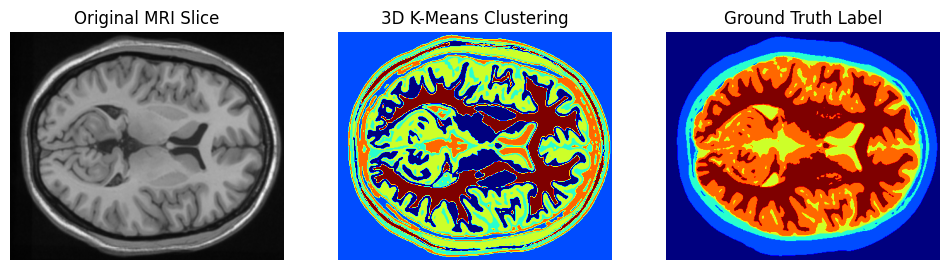

In [138]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from sklearn.cluster import KMeans
from skimage.filters import threshold_otsu
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
# from tqdm import tqdm

# Load data
data = loadmat('Brain.mat')
T1 = data['T1']  # Shape: (362, 434, 10)
label = data['label']  # Shape: (362, 434, 10)


# ========== 3D K-Means Segmentation ==========
def apply_3d_kmeans(mri_volume, n_clusters=6):
    # Flatten 3D volume
    mri_volume = (mri_volume - np.mean(mri_volume)) / np.std(mri_volume)
    mri_volume = gaussian(mri_volume, sigma=1)
    pixels = mri_volume.flatten().reshape(-1, 1)
    # kmeans = KMeans(n_clusters=n_clusters).fit(pixels)
    # pixels = gaussian(pixels, sigma=2)
    kmeans = KMeans(n_clusters=n_clusters, random_state=3).fit(pixels)
    clustered = kmeans.labels_.reshape(mri_volume.shape)
    return clustered

kmeans_result = apply_3d_kmeans(T1)

# Visualize 3D K-Means results (e.g., one slice)
slice_idx = T1.shape[2] // 2  # Middle slice
plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
plt.imshow(T1[:, :, slice_idx], cmap='gray')
plt.title('Original MRI Slice')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(kmeans_result[:, :, slice_idx], cmap='jet')
plt.title('3D K-Means Clustering')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(label[:, :, slice_idx], cmap='jet')
plt.title('Ground Truth Label')
plt.axis('off')

plt.show()


In [139]:
aligned_kmeans = align_labels(kmeans_result, label)
df_kmeans = compute_metrics(aligned_kmeans, label)

# Get average metrics for K-Means
average_dice_kmeans = df_kmeans['Dice'].mean()
average_iou_kmeans = df_kmeans['IoU'].mean()
average_accuracy_kmeans = df_kmeans['Accuracy'].mean()
average_nsd_kmeans = df_kmeans['NSD'].mean()

# create a summary dataframe
summary = pd.DataFrame({
    'Method': ['K-Means'],
    'Average Dice': [average_dice_kmeans],
    'Average IoU': [average_iou_kmeans],
    'Average Accuracy': [average_accuracy_kmeans],
    'Average NSD': [average_nsd_kmeans]
})

print("\nSummary of Average Metrics 3D K Means:")
summary


Summary of Average Metrics 3D K Means:


Method  Average Dice  Average IoU  Average Accuracy  Average NSD
0  K-Means       0.55008     0.469966          0.873879     0.383362

3D Filtering + Multi Otsu Thresholding

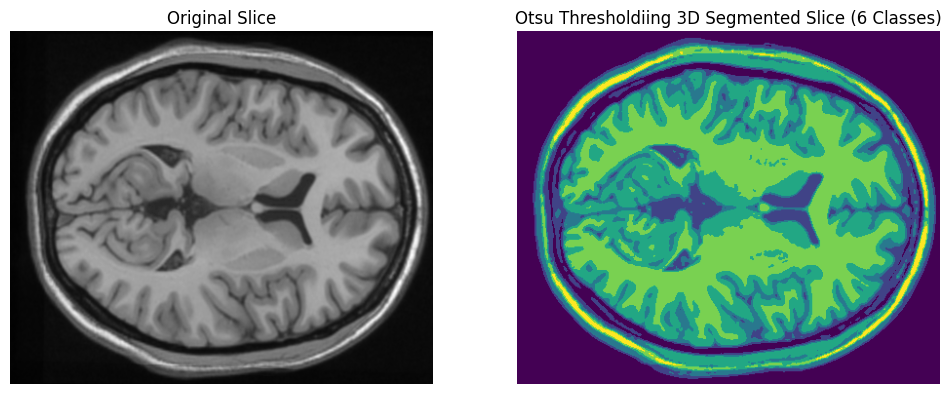

In [140]:
from skimage.filters import threshold_multiotsu
import numpy as np
import matplotlib.pyplot as plt

def multilevel_thresholding_3d(volume, num_classes):
    """
    Perform multilevel thresholding on a 3D volume.
    
    Parameters:
        volume (np.ndarray): 3D volume (e.g., MRI data).
        num_classes (int): Number of intensity-based classes to segment.
        
    Returns:
        thresholds (list): Computed threshold values.
        segmented (np.ndarray): Segmented 3D volume.
    """
    # Flatten the 3D volume for threshold computation
    flattened = volume.ravel()

    # # Apply Gaussian blur
    # smoothed = gaussian(flattened, sigma=1.5)
    
    # Compute multi-Otsu thresholds
    thresholds = threshold_multiotsu(flattened, classes=num_classes)
    
    # Segment the 3D volume using the thresholds
    segmented = np.digitize(volume, bins=thresholds)

    # Reshape the segmented array back to 3D
    segmented = segmented.reshape(volume.shape)

    return thresholds, segmented

# Example usage with T1
# Assume T1 is a 3D MRI image array
num_classes = 6  # Number of desired classes
thresholds, segmented_volume = multilevel_thresholding_3d(T1, num_classes)

# Compute metrics for the segmented volume
segmented_volume_aligned = align_labels(segmented_volume, label)
segmented_metrics = compute_metrics(segmented_volume_aligned, label)

# Visualize one slice of the segmented volume
slice_idx = T1.shape[2] // 2  # Middle slice
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(T1[:, :, slice_idx], cmap='gray')
plt.title("Original Slice")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(segmented_volume[:, :, slice_idx], cmap='viridis')
plt.title(f"Otsu Thresholdiing 3D Segmented Slice ({num_classes} Classes)")
plt.axis("off")

plt.show()


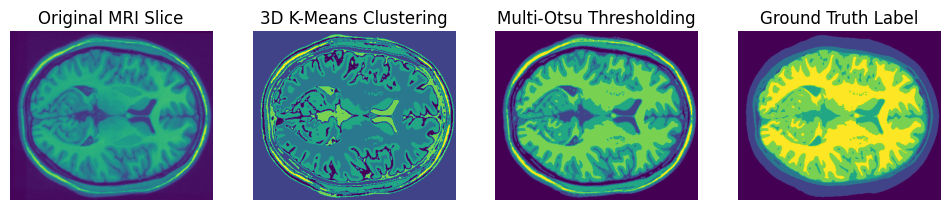

In [141]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from sklearn.cluster import KMeans
from skimage.filters import threshold_otsu
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
# from tqdm import tqdm

# Load data
data = loadmat('Brain.mat')
T1 = data['T1']  # Shape: (362, 434, 10)
label = data['label']  # Shape: (362, 434, 10)


# ========== 3D K-Means Segmentation ==========
def apply_3d_kmeans(mri_volume, n_clusters=6):
    # Flatten 3D volume
    pixels = mri_volume.flatten().reshape(-1, 1)
    kmeans = KMeans(n_clusters=n_clusters).fit(pixels)
    clustered = kmeans.labels_.reshape(mri_volume.shape)
    return clustered

kmeans_result = apply_3d_kmeans(T1)
thresholds, segmented_volume = multilevel_thresholding_3d(T1, num_classes)

# Visualize 3D K-Means results (e.g., one slice)
slice_idx = T1.shape[2] // 2  # Middle slice
plt.figure(figsize=(12, 6))
plt.subplot(1, 4, 1)
plt.imshow(T1[:, :, slice_idx])
plt.title('Original MRI Slice')
plt.axis('off')

plt.subplot(1, 4, 2)
plt.imshow(kmeans_result[:, :, slice_idx], cmap='viridis')
plt.title('3D K-Means Clustering')
plt.axis('off')

plt.subplot(1, 4, 3)
plt.imshow(segmented_volume[:, :, slice_idx], cmap='viridis')
plt.title('Multi-Otsu Thresholding')
plt.axis('off')

plt.subplot(1, 4, 4)
plt.imshow(label[:, :, slice_idx], cmap='viridis')
plt.title('Ground Truth Label')
plt.axis('off')

plt.show()


In [142]:
segmented_metrics = compute_metrics(segmented_volume_aligned, label)

# get the average values for each metric for all classes
average_dice = segmented_metrics['Dice'].mean()
average_iou = segmented_metrics['IoU'].mean()
average_accuracy = segmented_metrics['Accuracy'].mean()
average_nsd = segmented_metrics['NSD'].mean()


# create a summary dataframe
summary = pd.DataFrame({
    'Method': ['Multi-Level Thresholding'],
    'Average Dice': [average_dice],
    'Average IoU': [average_iou],
    'Average Accuracy': [average_accuracy],
    'Average NSD': [average_nsd]
})

print("\nSummary of Average Metrics:")
summary


Summary of Average Metrics:


Method  Average Dice  Average IoU  Average Accuracy  \
0  Multi-Level Thresholding      0.586615     0.514075          0.918608   

   Average NSD  
0     0.439109

In [143]:
import time
from sklearn.cluster import KMeans
from skimage.filters import threshold_multiotsu

# Function to apply 2D KMeans on each slice
def apply_2d_kmeans(mri_volume, n_clusters=6):
    clustered_slices = []
    for i in range(mri_volume.shape[2]):
        slice_2d = mri_volume[:, :, i]
        slice_2d = (slice_2d - np.mean(slice_2d)) / np.std(slice_2d)
        slice_2d = gaussian(slice_2d, sigma=1)
        pixels = slice_2d.flatten().reshape(-1, 1)
        kmeans = KMeans(n_clusters=n_clusters, random_state=3).fit(pixels)
        clustered = kmeans.labels_.reshape(slice_2d.shape)
        clustered_slices.append(clustered)
    return np.stack(clustered_slices, axis=2)

# Function to apply 3D KMeans
def apply_3d_kmeans(mri_volume, n_clusters=6):
    mri_volume = (mri_volume - np.mean(mri_volume)) / np.std(mri_volume)
    mri_volume = gaussian(mri_volume, sigma=1)
    pixels = mri_volume.flatten().reshape(-1, 1)
    kmeans = KMeans(n_clusters=n_clusters, random_state=3).fit(pixels)
    clustered = kmeans.labels_.reshape(mri_volume.shape)
    return clustered

# Function to apply 2D Multi Otsu on each slice
def apply_2d_multi_otsu(mri_volume, num_classes=6):
    segmented_slices = []
    for i in range(mri_volume.shape[2]):
        slice_2d = mri_volume[:, :, i]
        thresholds = threshold_multiotsu(slice_2d, classes=num_classes)
        segmented = np.digitize(slice_2d, bins=thresholds)
        segmented_slices.append(segmented)
    return np.stack(segmented_slices, axis=2)

# Function to apply 3D Multi Otsu
def apply_3d_multi_otsu(mri_volume, num_classes=6):
    flattened = mri_volume.ravel()
    thresholds = threshold_multiotsu(flattened, classes=num_classes)
    segmented = np.digitize(mri_volume, bins=thresholds)
    return segmented

# Measure time for 2D KMeans
start_time = time.time()
kmeans_2d_result = apply_2d_kmeans(T1)
time_2d_kmeans = time.time() - start_time

# Measure time for 3D KMeans
start_time = time.time()
kmeans_3d_result = apply_3d_kmeans(T1)
time_3d_kmeans = time.time() - start_time

# Measure time for 2D Multi Otsu
start_time = time.time()
multi_otsu_2d_result = apply_2d_multi_otsu(T1)
time_2d_multi_otsu = time.time() - start_time

# Measure time for 3D Multi Otsu
start_time = time.time()
multi_otsu_3d_result = apply_3d_multi_otsu(T1)
time_3d_multi_otsu = time.time() - start_time

# Print the results
print(f"Time for 2D KMeans: {time_2d_kmeans:.4f} seconds")
print(f"Time for 3D KMeans: {time_3d_kmeans:.4f} seconds")
print(f"Time for 2D Multi Otsu: {time_2d_multi_otsu:.4f} seconds")
print(f"Time for 3D Multi Otsu: {time_3d_multi_otsu:.4f} seconds")

Time for 2D KMeans: 0.4333 seconds
Time for 3D KMeans: 0.3625 seconds
Time for 2D Multi Otsu: 997.1679 seconds
Time for 3D Multi Otsu: 98.1392 seconds
